COnstruction year and population deleted due to 32% missing values... --> Try it with fancy impute. 


Outlier removal überarbeiten

# Predicting Water Pumps functionality

In [545]:
import numpy as np 
import pandas as pd
import missingno as mn #y
import seaborn as sns #y
from scipy import stats
import matplotlib.pyplot as plt
import os

import xgboost as xgb #ja
from sklearn.preprocessing import LabelEncoder #ja
from sklearn import model_selection, preprocessing # ja
from sklearn.model_selection import KFold #ja
from sklearn.metrics import mean_squared_error #ja
import pickle 



import re #y
import nltk #y
import multiprocessing #y
from sklearn.model_selection import train_test_split #y
from gensim.models.doc2vec import Doc2Vec, TaggedDocument #y
from tqdm import tqdm # y, for progress bars  
from sklearn import utils #y


from math import sqrt
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
import skopt
from skopt.plots import plot_convergence



from time import time, strftime, localtime
from datetime import timedelta
from sklearn.metrics import mean_squared_error

In [546]:
training_set = pd.read_csv("/notebooks/iss-katharinabaur/Project/Training_set_values.csv")

In [547]:
training_set

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


In [548]:
labels = pd.read_csv("/notebooks/iss-katharinabaur/Project/Training_set_labels.csv")

In [549]:
labels

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional
...,...,...
59395,60739,functional
59396,27263,functional
59397,37057,functional
59398,31282,functional


In [550]:
(labels["id"] == training_set["id"]).value_counts()

True    59400
Name: id, dtype: int64

In [551]:
training_set.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

###### Columns 


    amount_tsh - Total static head (amount water available to waterpoint)
    date_recorded - The date the row was entered
    funder - Who funded the well
    gps_height - Altitude of the well
    installer - Organization that installed the well
    longitude - GPS coordinate
    latitude - GPS coordinate
    wpt_name - Name of the waterpoint if there is one
    ##num_private -
    basin - Geographic water basin
    ##subvillage - Geographic location
    ##region - Geographic location
    ##region_code - Geographic location (coded)
    ##district_code - Geographic location (coded)
    lga - Geographic location
    ward - Geographic location
    population - Population around the well
    public_meeting - True/False
    recorded_by - Group entering this row of data
    scheme_management - Who operates the waterpoint
    scheme_name - Who operates the waterpoint
    permit - If the waterpoint is permitted
    construction_year - Year the waterpoint was constructed
    extraction_type - The kind of extraction the waterpoint uses
    ##extraction_type_group - The kind of extraction the waterpoint uses
    ##extraction_type_class - The kind of extraction the waterpoint uses
    management - How the waterpoint is managed
    management_group - How the waterpoint is managed
    payment - What the water costs
    ## payment_type - What the water costs
    water_quality - The quality of the water
    ##quality_group - The quality of the water
    quantity - The quantity of water
    ##quantity_group - The quantity of water
    source - The source of the water
    ##source_type - The source of the water
    source_class - The source of the water
    waterpoint_type - The kind of waterpoint
    ## waterpoint_type_group - The kind of waterpoint


In [552]:
training_set=training_set.drop(["extraction_type_group", "extraction_type_class", "management_group", "payment", "quality_group", "quantity_group", "source_type", "waterpoint_type_group"], axis=1)

In [554]:
training_set[ :1]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,permit,construction_year,extraction_type,management,payment_type,water_quality,quantity,source,source_class,waterpoint_type
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,False,1999,gravity,vwc,annually,soft,enough,spring,groundwater,communal standpipe


In [555]:
labels=labels.rename(columns={"id": "id2"})


In [556]:
df = pd.concat([training_set, labels], axis=1, sort=False)

In [558]:
df["id"].equals(df["id2"])

True

In [559]:
df=df.drop(["id2"], axis=1)

In [560]:
# drop duplicates 


df.drop_duplicates(subset ="id", keep = False, inplace= True )
df= df.reset_index(drop= True)

In [562]:
# Missing Values 


percentagemv= (df.isnull().sum()/df.index.size*100).round(2)
display(percentagemv)

id                    0.00
amount_tsh            0.00
date_recorded         0.00
funder                6.12
gps_height            0.00
installer             6.15
longitude             0.00
latitude              0.00
wpt_name              0.00
num_private           0.00
basin                 0.00
subvillage            0.62
region                0.00
region_code           0.00
district_code         0.00
lga                   0.00
ward                  0.00
population            0.00
public_meeting        5.61
recorded_by           0.00
scheme_management     6.53
scheme_name          47.42
permit                5.14
construction_year     0.00
extraction_type       0.00
management            0.00
payment_type          0.00
water_quality         0.00
quantity              0.00
source                0.00
source_class          0.00
waterpoint_type       0.00
status_group          0.00
dtype: float64

In [563]:
df = df.drop(["scheme_name"], axis=1)

In [564]:
import missingno as mn

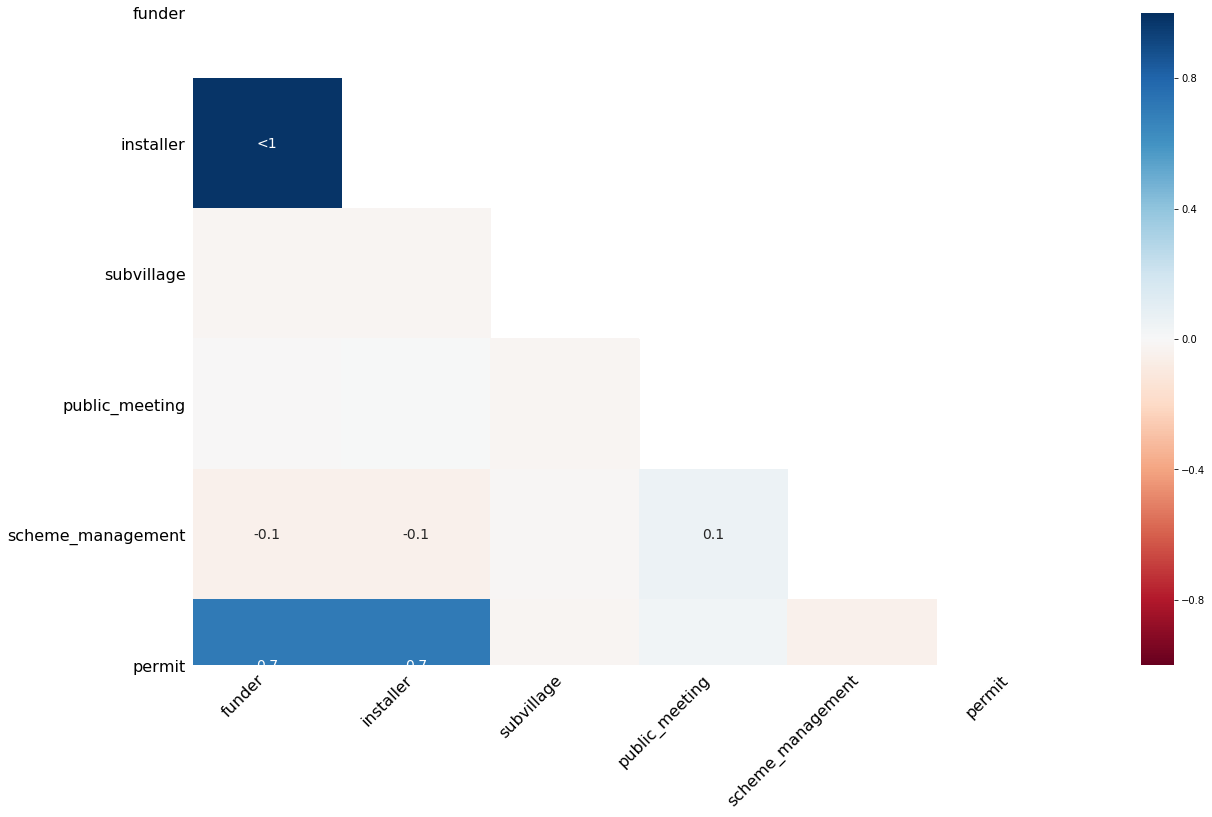

In [565]:
mn.heatmap(df)

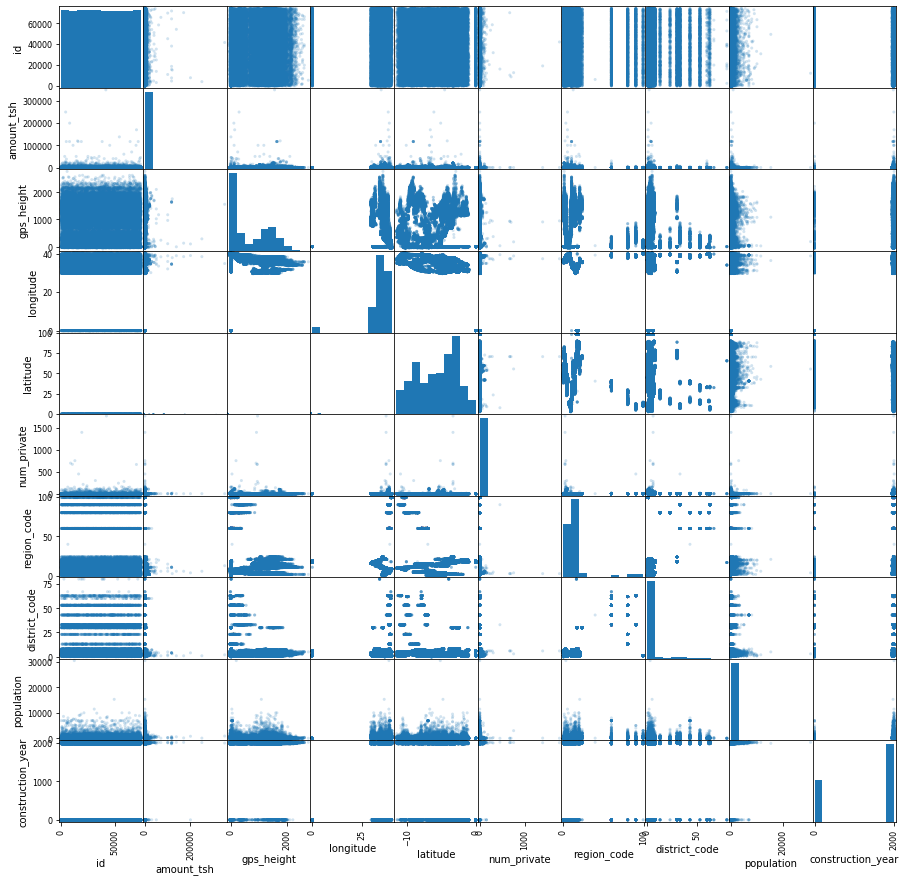

In [452]:
from pandas.plotting import scatter_matrix

scatter= scatter_matrix(df, alpha=0.2, figsize= (15,15))
scatter[4,1].set_xlim(0,400)
scatter[4,2].set_xlim(0,30)
scatter[4,3].set_xlim(0,300)
scatter[4,0].set_ylim(0,100)
scatter[4,1].set_ylim(0,100)
scatter[4,2].set_ylim(0,100)
scatter[4,3].set_ylim(0,100)


plt.show()

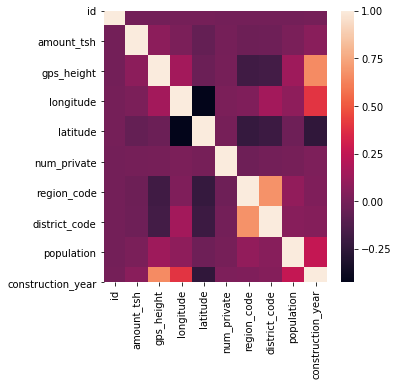

In [566]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(5,5))
sns.heatmap(df.corr());

In [567]:
df.corr()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
id,1.000000,-0.005321,-0.004692,-0.001348,0.001718,-0.002629,-0.003028,-0.003044,-0.002813,-0.002082
amount_tsh,-0.005321,1.000000,0.076650,0.022134,-0.052670,0.002944,-0.026813,-0.023599,0.016288,0.067915
gps_height,-0.004692,0.076650,1.000000,0.149155,-0.035751,0.007237,-0.183521,-0.171233,0.135003,0.658727
longitude,-0.001348,0.022134,0.149155,1.000000,-0.425802,0.023873,0.034197,0.151398,0.086590,0.396732
latitude,0.001718,-0.052670,-0.035751,-0.425802,1.000000,0.006837,-0.221018,-0.201020,-0.022152,-0.245278
num_private,-0.002629,0.002944,0.007237,0.023873,0.006837,1.000000,-0.020377,-0.004478,0.003818,0.026056
region_code,-0.003028,-0.026813,-0.183521,0.034197,-0.221018,-0.020377,1.000000,0.678602,0.094088,0.031724
district_code,-0.003044,-0.023599,-0.171233,0.151398,-0.201020,-0.004478,0.678602,1.000000,0.061831,0.048315
population,-0.002813,0.016288,0.135003,0.086590,-0.022152,0.003818,0.094088,0.061831,1.000000,0.260910
construction_year,-0.002082,0.067915,0.658727,0.396732,-0.245278,0.026056,0.031724,0.048315,0.260910,1.000000


In [457]:
BBox = (-12,  0,      
         28, 42)

In [458]:
BBox

(-12, 0, 28, 42)

In [459]:
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap


In [460]:


%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap



In [351]:
lat = df["latitude"].tolist()
long = df["longitude"].tolist()

latfunc = df.loc[df["status_group"] == "functional", 'latitude'].tolist()
longfunc = df.loc[df["status_group"] == "functional", 'longitude'].tolist()


latnon = df.loc[df["status_group"] == "non functional", 'latitude'].tolist()
longnon = df.loc[df["status_group"] == "non functional", 'longitude'].tolist()


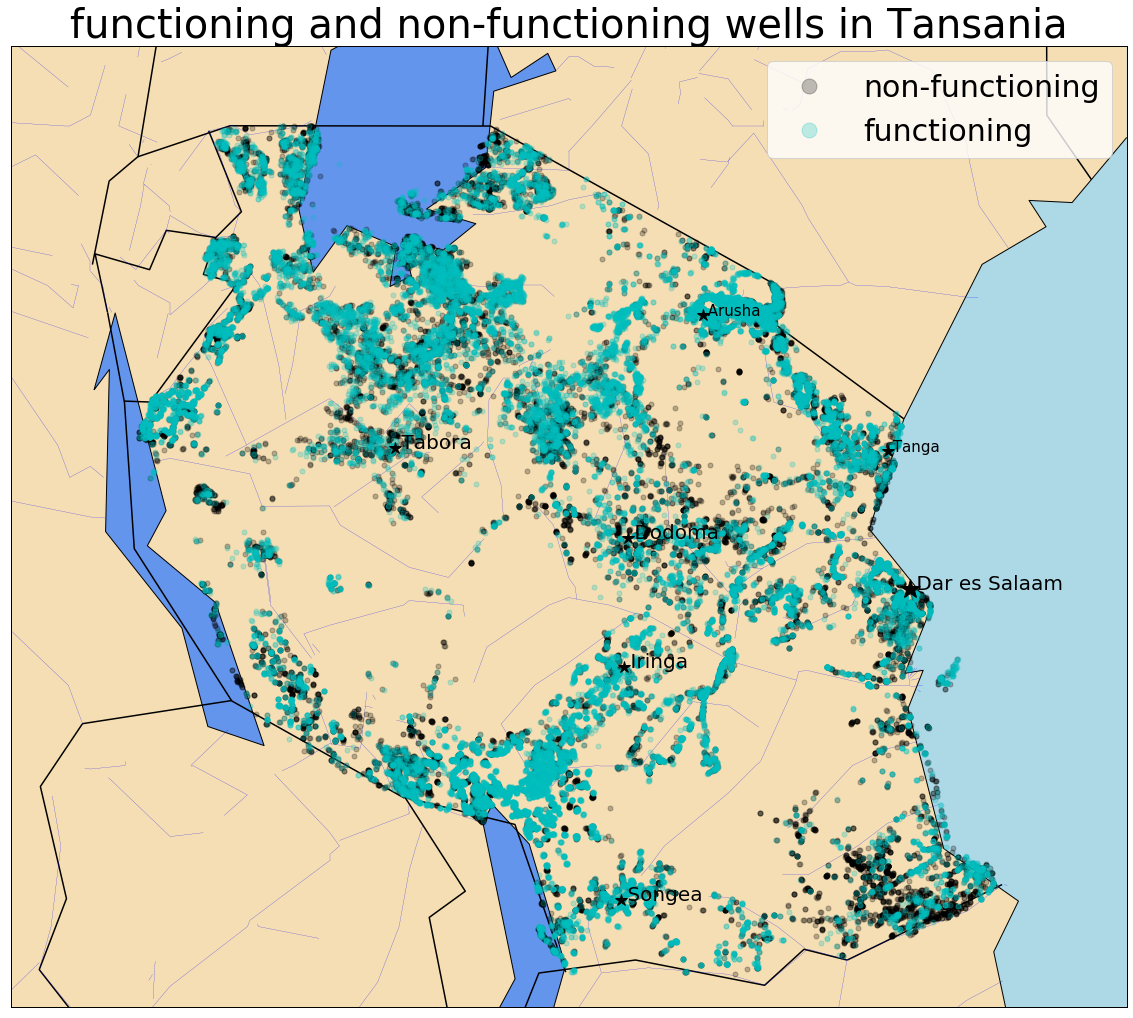

In [390]:
fig = plt.figure(figsize=(20,30))
m = Basemap(projection="mill", llcrnrlat= BBox[0], urcrnrlat=BBox[1], llcrnrlon= BBox[2], urcrnrlon= BBox[3], resolution= "c")

m.drawcoastlines()
#m.drawparallels(np.arange(-90,90,10), labels= [True, False, False, False])
#m.drawmeridians(np.arange(-180, 180, 30), labels= [0,0,0,1])
m.drawmapboundary(fill_color='lightblue')
m.drawcountries(linewidth=1.5, linestyle='solid', color='k' ) 
m.drawstates(linewidth=0.5, linestyle='solid', color='k')
m.drawrivers(linewidth=0.2, linestyle='solid', color='blue')
m.fillcontinents(color='wheat',lake_color='cornflowerblue')
a,b = m(longnon,latnon)
m.plot(a,b, "ko", markersize= 5, alpha= 0.25 )

x,y = m(longfunc,latfunc)
m.plot(x,y, "co" ,markersize= 5, alpha=0.25 )

x, y = m(39.279556, -6.802353)
plt.plot(x, y, '*k', markersize=20)
plt.text(x, y, ' Dar es Salaam', fontsize=20);

x, y = m(39, -5.06893)
plt.plot(x, y, '*k', markersize=13)
plt.text(x, y, ' Tanga', fontsize=15);


x, y = m(36.68333, -3.36667)
plt.plot(x, y, '*k', markersize=13)
plt.text(x, y, ' Arusha', fontsize=15);

x, y = m(35.745426,-6.161184 )
plt.plot(x, y, '*k', markersize=13)
plt.text(x, y, ' Dodoma', fontsize=20);

x, y = m(35.699120,-7.773094)
plt.plot(x, y, '*k', markersize=13)
plt.text(x, y, ' Iringa', fontsize=20);

x, y = m(32.819431,-5.030461)
plt.plot(x, y, '*k', markersize=13)
plt.text(x, y, ' Tabora', fontsize=20);


x, y = m(35.655785,-10.676803)
plt.plot(x, y, '*k', markersize=13)
plt.text(x, y, ' Songea', fontsize=20);


plt.title("functioning and non-functioning wells in Tansania", fontsize=40)
plt.legend(['non-functioning','functioning'], loc= "upper right", fontsize=30, markerscale= 3.0)




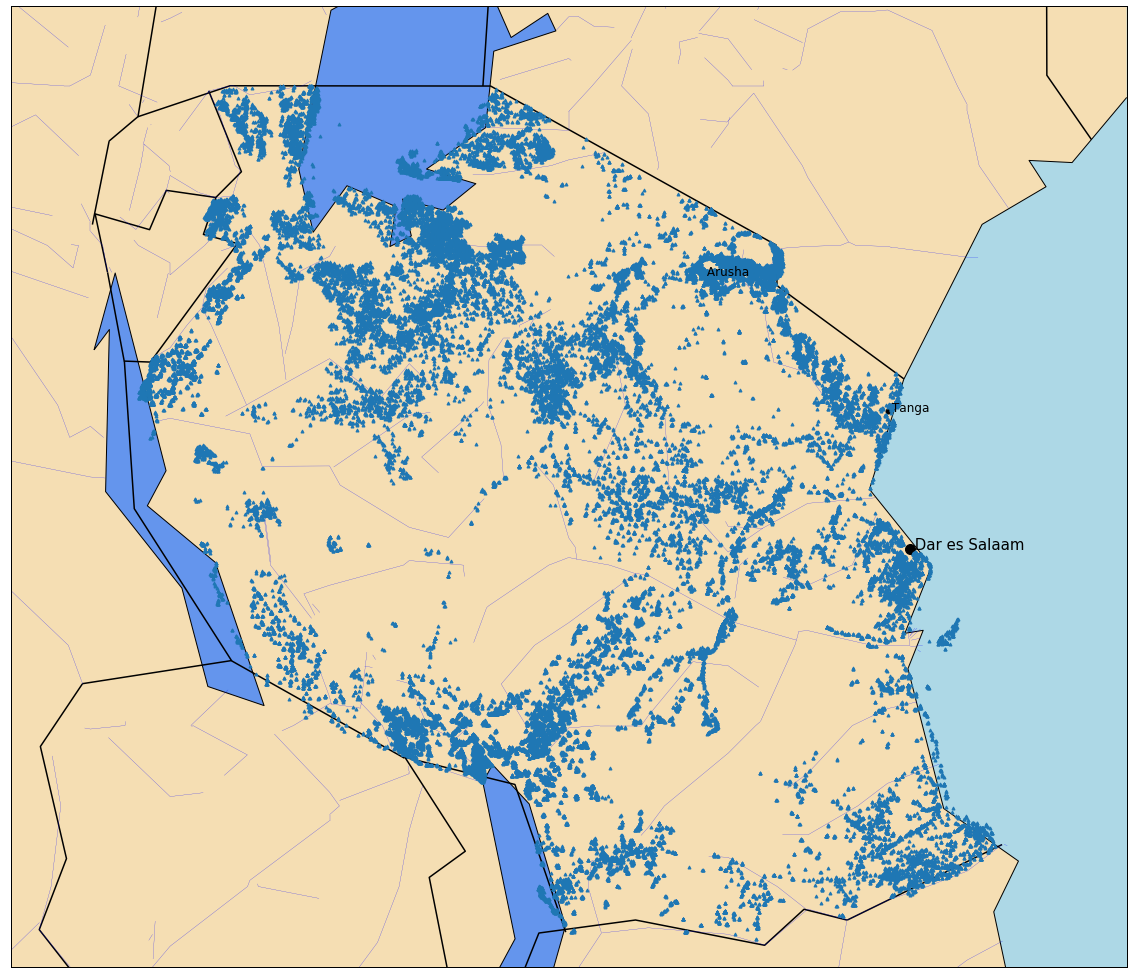

In [348]:
fig = plt.figure(figsize=(20,30))
m = Basemap(projection="mill", llcrnrlat= BBox[0], urcrnrlat=BBox[1], llcrnrlon= BBox[2], urcrnrlon= BBox[3], resolution= "c")

m.drawcoastlines()
#m.drawparallels(np.arange(-90,90,10), labels= [True, False, False, False])
#m.drawmeridians(np.arange(-180, 180, 30), labels= [0,0,0,1])
m.drawmapboundary(fill_color='lightblue')
m.drawcountries(linewidth=1.5, linestyle='solid', color='k' ) 
m.drawstates(linewidth=0.5, linestyle='solid', color='k')
m.drawrivers(linewidth=0.2, linestyle='solid', color='blue')
m.fillcontinents(color='wheat',lake_color='cornflowerblue')

x, y = m(39.279556, -6.802353)
plt.plot(x, y, 'ok', markersize=10)
plt.text(x, y, ' Dar es Salaam', fontsize=15);

x, y = m(39, -5.06893)
plt.plot(x, y, 'ok', markersize=5)
plt.text(x, y, ' Tanga', fontsize=12);


x, y = m(36.68333, -3.36667)
plt.plot(x, y, 'ok', markersize=7)
plt.text(x, y, ' Arusha', fontsize=12);


x,y = m(long,lat)
m.plot(x,y, "^" ,markersize= 3 )



### Missing Data 

In [568]:
df['population']=df['population'].replace(0, np.nan)

In [583]:


percentagemv= (df.isnull().sum()/df.index.size*100).round(2)
display(percentagemv)

id                    0.00
amount_tsh            0.00
date_recorded         0.00
funder                6.29
gps_height            0.00
installer             6.32
longitude             0.00
latitude              0.00
wpt_name              0.00
num_private           0.00
basin                 0.00
subvillage            0.65
region                0.00
region_code           0.00
district_code         0.00
lga                   0.00
ward                  0.00
public_meeting        5.17
recorded_by           0.00
scheme_management     6.52
permit                5.31
construction_year    32.86
extraction_type       0.00
management            0.00
payment_type          0.00
water_quality         0.00
quantity              0.00
source                0.00
source_class          0.00
waterpoint_type       0.00
status_group          0.00
dtype: float64

In [571]:
df = df.drop(["population"], axis=1)

In [585]:
df = df.drop(["construction_year"], axis=1)

In [587]:
df = df.drop(["num_private"], axis=1)

In [572]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 31 columns):
id                   59400 non-null int64
amount_tsh           59400 non-null float64
date_recorded        59400 non-null object
funder               55765 non-null object
gps_height           59400 non-null int64
installer            55745 non-null object
longitude            59400 non-null float64
latitude             59400 non-null float64
wpt_name             59400 non-null object
num_private          59400 non-null int64
basin                59400 non-null object
subvillage           59029 non-null object
region               59400 non-null object
region_code          59400 non-null int64
district_code        59400 non-null int64
lga                  59400 non-null object
ward                 59400 non-null object
public_meeting       56066 non-null object
recorded_by          59400 non-null object
scheme_management    55523 non-null object
permit               56344 non-nu

#### Outlier Removal 

In [573]:

df = df[df.amount_tsh < 20000]

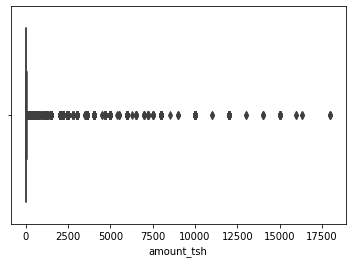

In [574]:
sns.boxplot(x= df["amount_tsh"])

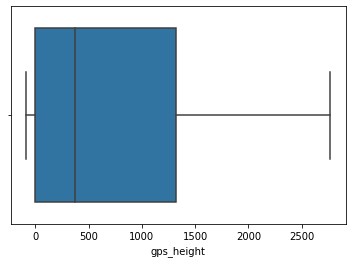

In [575]:
sns.boxplot(x= df["gps_height"])
#no outliers

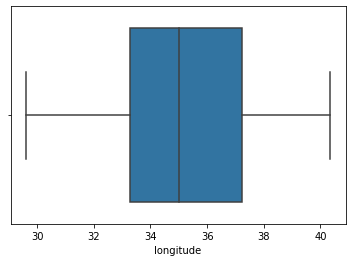

In [576]:
df = df[df.longitude > 15]
sns.boxplot(x= df["longitude"])


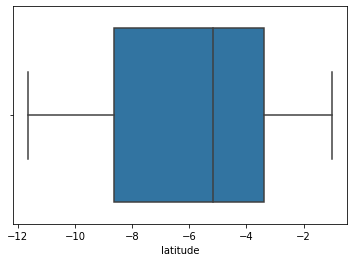

In [577]:
sns.boxplot(x= df["latitude"])

In [581]:
df['construction_year']=df['construction_year'].replace(0, np.nan)

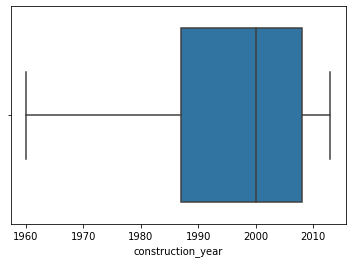

In [584]:


sns.boxplot(x= df["construction_year"])


In [589]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 57491 entries, 0 to 59399
Data columns (total 29 columns):
id                   57491 non-null int64
amount_tsh           57491 non-null float64
date_recorded        57491 non-null object
funder               53873 non-null object
gps_height           57491 non-null int64
installer            53859 non-null object
longitude            57491 non-null float64
latitude             57491 non-null float64
wpt_name             57491 non-null object
basin                57491 non-null object
subvillage           57120 non-null object
region               57491 non-null object
region_code          57491 non-null int64
district_code        57491 non-null int64
lga                  57491 non-null object
ward                 57491 non-null object
public_meeting       54519 non-null object
recorded_by          57491 non-null object
scheme_management    53741 non-null object
permit               54437 non-null object
extraction_type      57491 non-n

In [591]:
df.loc[df["gps_height"]==0]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,...,permit,extraction_type,management,payment_type,water_quality,quantity,source,source_class,waterpoint_type,status_group
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,Lake Victoria,...,True,gravity,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,functional
5,9944,20.0,2011-03-13,Mkinga Distric Coun,0,DWE,39.172796,-4.765587,Tajiri,Pangani,...,True,submersible,vwc,per bucket,salty,enough,other,unknown,communal standpipe multiple,functional
6,19816,0.0,2012-10-01,Dwsp,0,DWSP,33.362410,-3.766365,Kwa Ngomho,Internal,...,True,swn 80,vwc,never pay,soft,enough,machine dbh,groundwater,hand pump,non functional
7,54551,0.0,2012-10-09,Rwssp,0,DWE,32.620617,-4.226198,Tushirikiane,Lake Tanganyika,...,True,nira/tanira,wug,unknown,milky,enough,shallow well,groundwater,hand pump,non functional
8,53934,0.0,2012-11-03,Wateraid,0,Water Aid,32.711100,-5.146712,Kwa Ramadhan Musa,Lake Tanganyika,...,True,india mark ii,vwc,never pay,salty,seasonal,machine dbh,groundwater,hand pump,non functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59384,72148,0.0,2011-07-10,Concern,0,CONCERN,30.667805,-2.483710,Chamkube,Lake Victoria,...,False,gravity,vwc,never pay,soft,insufficient,spring,groundwater,communal standpipe,non functional
59392,40607,0.0,2011-04-15,Government Of Tanzania,0,Government,33.009440,-8.520888,Benard Charles,Lake Rukwa,...,True,gravity,vwc,never pay,soft,enough,spring,groundwater,communal standpipe,non functional
59393,48348,0.0,2012-10-27,Private,0,Private,33.866852,-4.287410,Kwa Peter,Internal,...,False,gravity,private operator,per bucket,soft,insufficient,dam,surface,other,functional
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,Rufiji,...,False,swn 80,vwc,monthly,fluoride,enough,machine dbh,groundwater,hand pump,functional
